# PlotStripsData
## Loads saved strip information and makes some plots.  Also calculates the pixel to micron conversion.
#### Catherine Nicoloff, Wellesley College, June 2017
#### On behalf of Brandeis University and Brookhaven National Laboratory for the ATLAS ITk upgrade.

#### Turn on autoreload

In [3]:
%load_ext autoreload

<p><b>%autoreload</b>: Reload all modules (except those excluded by %aimport) automatically now.<br>
<b>%autoreload 0</b>: Disable automatic reloading.<br>
<b>%autoreload 1</b>: Reload all modules imported with %aimport every time before executing the Python code typed.<br>
<b>%autoreload 2</b>: Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.</p>
<p><b>%aimport</b>: List modules which are to be automatically imported or not to be imported.<br>
<b>%aimport foo</b>: Import module ‘foo’ and mark it to be autoreloaded for %autoreload 1<br>
<b>%aimport -foo</b>: Mark module ‘foo’ to not be autoreloaded.</p>

In [4]:
%autoreload 2

#### Show plots in the notebook

In [5]:
%matplotlib inline

#### Load modules

In [18]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import cv2
import os
import sys
import re
import csv

#### Load additional definitions

In [19]:
import process_strips as p

#### Set plot formatting defaults

In [20]:
plt.style.use('classic')
plt.rcParams['figure.figsize'] = (15.0, 10.0)
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18

#### Local definitions

In [21]:
# Turn a list into an array
def make_array(my_list):
    return [np.array(row) for row in my_list]

# Get a column out of a matrix
def get_column(my_array, col):
    return np.array([np.array(row)[col] for row in my_array])

# Get critical points of a function
def get_critical_points(p, left, right):
    bounds = [left, right]
    crit_points = bounds + [x for x in p.deriv().r if x.imag == 0 and bounds[0] < x.real < bounds[1]]
    return crit_points

# Try to plot a strips's location and fit a line through it
def plot_strips(x, means, devs, save_dir, file_num):
    
    # Get the dimensions of the 2D array
    l, w = np.shape(means)
    
    thetas = []
    chi = []
    strip_loc = []
    strip_num = []
    lines = []

    # Iterate the columns
    for i in range(0, w-1):
        
        # Grab that column value from each row
        yy = np.array([row[i] for row in means], dtype=float)
        ss = np.array([row[i] for row in devs], dtype=float)
        xx = x
        
        # Remove any zeroes, as they are the result of failed fits
        z = np.where(yy > 0.0)[0]
        
        yy = yy[z]
        ss = ss[z]
        xx = xx[z]

        # Make sure the data isn't empty
        if (len(yy) > 1 and len(ss) > 1):

            # Fix anything that might be an invalid value
            yy = p.fix_broken_values(yy, 0.0)
            ss = p.fix_broken_values(ss, 0.0001)

            # Look for outliers
            o = p.detect_outliers(xx, yy, ss, 1, 20.0, 15.0)

            # Cull outliers
            yy = yy[o]
            xx = xx[o]
            ss = ss[o]

            # Make sure the data isn't empty
            if (len(yy) > 1 and len(ss) > 1):
                ss = ss # * 1.525

                # Unsquare sigma
                sqrt_s = np.sqrt(ss)

                # Fit a line
                popt, pcov = np.polyfit(xx, yy, 1, w=1.0/sqrt_s, cov=True)
                poly = np.poly1d(popt)
                lines.append([popt, np.diag(pcov)])

                # Chi squared
                cs = p.calc_chisquare(poly(xx), yy, ss, len(yy)-2)
                chi.append(cs)

                strip_loc.append([popt[1], np.sqrt(np.diag(pcov)[1])])

                plt.errorbar(xx, yy, yerr=sqrt_s, fmt='ko', ecolor='k', alpha=0.10, zorder=1)
                plt.plot(x, poly(x), 'b--', lw=3, label="Fit Line: %s" % poly, zorder=2)
                plt.title("Strip %d, $\chi^2$ = %f" % (i, cs))
                plt.xlabel("X Location [pixels]")
                plt.ylabel("Y Location [pixels]")
                plt.legend(loc='best')
                plt.ticklabel_format(useOffset=False)
                plt.savefig("%s/%d_strip_%d.png" % (save_dir, file_num, i), dpi=300)
                plt.show()
                
    return strip_num, strip_loc, chi

# Take all the chi-squared results and visualize the spherical aberration of the camera
def visualize_aberration(x, means, devs, save_dir, file_num):
    strip_num, strip_loc, chi = plot_strips(x, means, devs, save_dir, file_num)

    strips = get_column(strip_loc, 0)
    fit, covb = np.polyfit(strips, chi, 2, cov=True)
    poly = np.poly1d(fit)
    crit = get_critical_points(poly, strips[0], strips[-1])
    min_chi = np.min(crit)

    plt.plot(strips, chi, 'bo', lw=3)
    plt.plot(strips, np.polyval(fit, strips), 'g--', lw=2, label="Minimum: %1.3f" % min_chi)
    plt.title("Evolution of $\chi^2$")
    plt.xlabel("Strip Location [Pixels]")
    plt.ylabel("$\chi^2/D.O.F.$")
    plt.legend(loc='best')
    plt.savefig("%s/chi_squared.png" % (save_dir), dpi=300)
    plt.show()

# Define a gaussian distribution
def gauss(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2.0 / (2 * sigma**2))

# Calculate an optimal number of bins
def get_numbins(data):
    # Freedman-Diaconis
    IQR = np.subtract(*np.percentile(data, [75, 25]))
    h = (2 * IQR / (len(data)**(1/3)))
    numbins = int((np.nanmax(data) - np.nanmin(data)) / h)
    return numbins

# Trim anything more than n standard deviations from the mean
def trim_n_stddev(data, mean, std, n):
    data_trim = data.copy()
    data_trim = data_trim[data_trim <= mean + n*std]
    data_trim = data_trim[data_trim >= mean - n*std]
    return data_trim

## Plot Things

#### Local variables

In [43]:
# Size of rectangle to analyze
rect = [3000, 3000]

# Analyze every nth column of the rectangle
step = 1

# Directory of images
img_dir = r'D:\Documents\School\Brookhaven\Images\2017-06-15\Fast Conversion Test'

# Directory to load processed strips data from
load_dir = r'%s\%dx%d\Step %d' % (img_dir, rect[0], rect[1], step)

# Directory where results are saved
save_dir = r'%s\Results' % (load_dir)

# Filename regex to match
match_pattern = "^([0-9]*)_results.csv$"

# Make the save directory, if it does not exist
p.make_dir(save_dir)

In [44]:
# Get list of files in the image directory
filenames = next(os.walk(load_dir))[2]

dist = []

# Iterate all the files
for fn in filenames:
    # Regex match on the filenames
    match = re.search(match_pattern, fn)

    # Pattern matched
    if match:
        # Get the file number
        try:
            file_num = int(match.group(1))
        except:
            file_num = 1

        load_file = r'%s\%d_results.csv' % (load_dir, file_num) 
        print("Loading results from %s..." % (fn))

        x, means, devs, dx = p.load_results(load_file, header=True)
        dist.append(np.array(dx))
        
        #visualize_curvature(x, means, devs, save_dir, file_num)

Loading results from 1_results.csv...


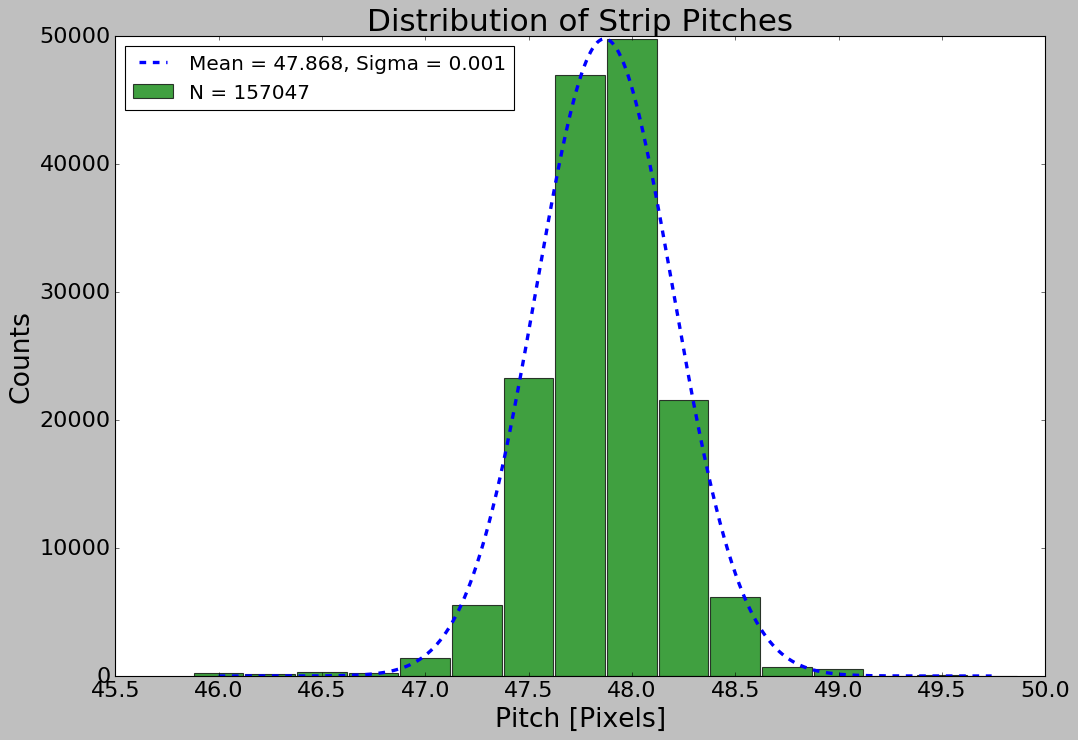

In [45]:
pitches = []

# Collect all the strip pitch values
for i in range(len(dist)):
    for j in range(len(dist[i])):
        for k in range(len(dist[i][j])):
            if (dist[i][j][k] is not None):
                pitches.append(dist[i][j][k])
                
# Make sure it's an array
pitches = np.array(pitches)

# Rough chop to remove impossible values
pitches = pitches[pitches > 44.0]
pitches = pitches[pitches < 50.0]

# Get mode and std of the pitches
mode = stats.mode(pitches)[0]
std = np.std(pitches)

# Trim out everything more than 3 standard deviations from the mode
pitches_trim = trim_n_stddev(pitches, mode, np.sqrt(std), 3.0)

# Put the trimmed data into a histogram
n, bins, patches = plt.hist(pitches_trim, bins='auto')
plt.close()

# Number of samples
N = len(pitches_trim)

# Get mean and std of the trimmed pitches
mean = np.mean(pitches_trim)
std = np.std(pitches_trim)

# Arbitrary cutoff of counts per bin
# This is to cull empty bins that happen due to the 1/4 integral nature of the data
locs = np.where(n > 0)
bins = bins[locs]
n = n[locs]

# Calculate a drawing width for the bins
# FIXME: This doesn't always work nicely with low N
bin_widths = np.gradient(bins)
bin_width = np.min(bin_widths)

# Un-normalize the fit
# FIXME: This is really hacky
amp = n[n == n.max()]

# Error is sqrt(std)/sqrt(N)
sqrt_std = np.sqrt(std/N)

# Create a smoother set of input values for the gaussian plot
x = np.linspace(bins[0], bins[-1], 1000)

# Plot the histogram with the gaussian fit
plt.bar(bins, n, facecolor='green', alpha=0.75, width=bin_width, align='center', label="N = %d" % N)
plt.plot(x, gauss(x, amp, mean, std), 'b--', lw=3, label="Mean = %2.3f, Sigma = %2.3f" % (mean, sqrt_std))
plt.title("Distribution of Strip Pitches")
plt.xlabel("Pitch [Pixels]")
plt.ylabel("Counts")
plt.legend(loc='best')
plt.savefig("%s/pitches.png" % (save_dir), dpi=300)
plt.show()

## Pixel to Micron Conversion

In [46]:
def save_results(filename, results, header=None):
    import csv
    with open(filename, "a", newline='') as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        if (header):
            writer.writerow(header)
        for line in results:
            writer.writerow(line)

def pixels_to_microns(microns, microns_err, pixels, pixels_err):
    factor = microns / pixels
    factor_err = np.sqrt(((-microns/pixels**2)*pixels_err)**2)
    
    return factor, factor_err

microns = 74.5
factor, factor_err = pixels_to_microns(microns, 0.0, mean, sqrt_std)

results = []
results.append([mean, sqrt_std, microns, 0.0, factor, factor_err])

save_results("%s/pixel_to_micron.csv" % (save_dir), results, ['Mean Strip Pitch [px]', 'Mean Strip Pitch Err [px]', 'Strip Pitch [um]', 'Strip Pitch Err [um]', 'Conversion [px/um]', 'Conversion Err [px/um]'])

print("Mean strip pitch: %1.3f pixels, pm %0.3f" %(mean, sqrt_std))
print("Conversion factor: %1.5f microns per pixel, pm %0.5f" %(factor, factor_err))

Mean strip pitch: 47.868 pixels, pm 0.001
Conversion factor: 1.55638 microns per pixel, pm 0.00005
